In [1]:
from __future__ import annotations

import itertools
# import logging
import os
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'
os.environ["VECLIB_MAXIMUM_THREADS"] = "4"
import numpy as np
import pandas as pd
from scipy.stats import norm

import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from segment_tree import MinSegmentTree, SumSegmentTree

from golds.contracts import Currency, Stock, Option, OptionFlavor, OptionStyle, Holdings, Valuation
from golds.env import AmericanOptionEnv
from golds.mkt_data import PricingSource, SingleStockGBMMarketDataSource
from golds.params import GBMParams
from golds.reward_functions import NaiveHedgingRewardFunction, RewardFunction
from golds.tcost import NaiveTransactionCostModel

In [2]:
INIT_STOCK_HOLDINGS = 0
GBM_MU = 0.02
GBM_SIGMA = 0.09 
GBM_R = 0.0 

EPISODE_LENGTH = 50
NUM_OUT_OF_SAMPLE_PATH = 100

REWARD_KAPPA = 0.01

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        n_step: int = 1, 
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: np.ndarray, 
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

In [4]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.
    
    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight
        
    """
    
    def __init__(
        self, 
        obs_dim: int, 
        size: int, 
        batch_size: int = 32, 
        alpha: float = 0.6,
        n_step: int = 1, 
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def store(
        self, 
        obs: np.ndarray, 
        act: int, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

In [5]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.
    
    
        
    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter
        
    """

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

In [6]:
class Network(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()
        
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set common feature layer
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
        )
        
        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(128, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(128, 128)
        self.value_layer = NoisyLinear(128, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x)
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist
    
    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

In [7]:
class RainbowAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        count: torch.Tensor,
        obs_input: pd.DataFrame,
        gamma: float = 0.99,
        # PER parameters
        alpha: float = 0.5,
        beta: float = 0.0,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 3,
        i: int = 0
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0001)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False
        
        self.i = 0
        self.count = count
        
        self.obs_input = obs_input

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        self.i += 1
        a = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ) + torch.sqrt(2 * np.log(self.i) / self.count).to(self.device)
        selected_action = a.argmax()
        self.count[0][selected_action] += 1
        selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 100):
        """Train the agent."""
        self.is_test = False
    
        state = self.env.reset()
        update_cnt = 0
        losses = []
        scores = []
        score = 0
        rewards = []

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            
            # NoisyNet: removed decrease of epsilon
            
            # PER: increase beta
            fraction = min(frame_idx / num_frames, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                prev_pos = None
                preds = []
                
                for _t in sorted(self.obs_input['normalized_time'].unique()):
                    prev_pos = np.ones(self.obs_input['episode_idx'].max() + 1) * INIT_STOCK_HOLDINGS if prev_pos is None else prev_pos
                    obs = np.hstack([self.obs_input.loc[self.obs_input['normalized_time'] == _t, ['price', 'call_price', 'all_1','normalized_time',]].values, prev_pos[:, np.newaxis], np.zeros((self.obs_input['episode_idx'].max() + 1, 2))])
                    pred = np.zeros(len(obs))
                    for j in range(len(obs)):
                        pred[j] = self.select_action(obs[j]) - 100
                    prev_pos = pred
                    preds.append(pred)
                    
                self.obs_input['holdings'] = np.concatenate(preds)
                self.obs_input = self.obs_input.sort_values(['episode_idx', 'normalized_time'])
                self.obs_input = self._calculate_reward_vectorize(self.obs_input)
                
                action_fn_df: pd.DataFrame = self.obs_input[['holdings', 'reward']]
                    
                rewards.append(action_fn_df.reward.median())
                
                stock_price_list = [98, 100, 102]

                for price in stock_price_list:   
                    mu = GBM_MU / 252
                    sigma = GBM_SIGMA / np.sqrt(252)
                    r = GBM_R / 252

                    stock_holdings = np.arange(-100,-19)
                    obs_length = len(stock_holdings)
                    stock_price = np.repeat(price, obs_length)
                    obs_3 = np.repeat(1, obs_length)
                    time_to_maturity = np.repeat(49 / 252, obs_length)
                    obs_6 = np.repeat(0, obs_length)
                    obs_7 = np.repeat(0, obs_length)
                    t = 49/50

                    res = pd.DataFrame.from_dict({'stock_price': stock_price, 'obs_3': obs_3, 'stock_holdings': stock_holdings, 
                                             'time_to_maturity':time_to_maturity, 'obs_6': obs_6,'obs_7': obs_7, 't':t})
                    res['delta'] = norm.cdf((np.log(res['stock_price'] / 100) + (r * 252 + 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) /\
                        np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
                    res['call_price'] = res['stock_price'] * res['delta'] - 100 * np.exp(-r * 252 * (1 - res['time_to_maturity'])) * norm.cdf((np.log(res['stock_price'] / 100)\
                         + (r * 252 - 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) / np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))

                    obs = res[["stock_price","call_price","obs_3","t","stock_holdings","obs_6","obs_7"]].to_numpy()
                    
                    actions = np.zeros(len(obs))
                    for j in range(len(obs)):
                        actions[j] = self.select_action(obs[j]) - 100

                    if price < 100:
                        oom_actions = list(actions)
                    elif price == 100:
                        atm_actions = list(actions)
                    else:
                        itm_actions = list(actions)
                
                self._plot(frame_idx, scores, rewards, losses, oom_actions, atm_actions, itm_actions)
                
        self.env.close()
                
    def test(self) -> List[np.ndarray]:
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        return frames

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        
        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        rewards: List[float], 
        losses: List[float],
        oom_actions: List[float],
        atm_actions: List[float],
        itm_actions: List[float]
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(10, 25))
        plt.subplot(411)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(412)
        plt.plot(rewards, marker='x')
        plt.semilogx()
        plt.xlabel('Training Epochs')
        plt.ylabel('Accumulative Reward')
        plt.subplot(413)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(414)
        stock_holdings = np.arange(-100,-19)
        delta_oom = - stock_holdings
        delta_atm = -50 - stock_holdings
        delta_itm = -100 - stock_holdings
        plt.title('policy plot')
        plt.plot(stock_holdings, delta_oom, label="Delta Out of Money", color="red") 
        plt.plot(stock_holdings, delta_atm, label="Delta At The Money", color="blue") 
        plt.plot(stock_holdings, delta_itm, label="Delta In The Money", color="green") 
        plt.scatter(stock_holdings, oom_actions - stock_holdings, label="DQN Out of Money", color="red") 
        plt.scatter(stock_holdings, atm_actions - stock_holdings, label="DQN At The Money", color="blue") 
        plt.scatter(stock_holdings, itm_actions - stock_holdings, label="DQN In The Money", color="green") 
        plt.gca().invert_xaxis()
        plt.legend(loc='upper center', bbox_to_anchor=(1.15, 0.3), fancybox=True)
        plt.show()
    
    def _calculate_reward_vectorize(self, res: pd.DataFrame):
        res['delta_wealth'] = res['holdings'].shift() * res['price'] + 100 * res['call_price'] - (res['holdings'] * res['price'] + 100 * res['call_price']).shift()
        res.loc[res['normalized_time']==res['normalized_time'].min(), 'delta_wealth'] = 0.
        res['reward'] = res['delta_wealth'] ** 2 * -0.5 * REWARD_KAPPA
        return res

In [8]:
def get_training_environment(save_dir: str):
    aapl = Stock(ticker="AAPL", is_tradable=True)
    # TODO we can also make the option parameters part of the config
    warrant = Option(
        strike=100,
        expiry_time=1.,
        underlying=aapl,
        flavor=OptionFlavor.CALL,
        style=OptionStyle.EUROPEAN,
        is_tradable=False
    )
    cash = Currency(code="USD", is_tradable=False)

    initial_holdings: Holdings = {
        aapl: 0,
        warrant: 100,
        cash: 0,
    }

    universe = list(initial_holdings.keys())

    gbm_params = GBMParams(mu=GBM_MU, sigma=GBM_SIGMA, risk_free_rate=GBM_R)

    mkt_data_source = SingleStockGBMMarketDataSource(universe, gbm_params, data_reuse_num_episodes=10000)
    tcost_model = NaiveTransactionCostModel(universe)
    pricing_source = PricingSource(mkt_data_source, tcost_model)

    reward_clip_range = (-200, 200)
    reward_records_save_path = os.path.join(save_dir, "rainbow_reward_history.h5")

    valid_actions = {'lo': -100, 'hi': 100}

    reward_function: RewardFunction = NaiveHedgingRewardFunction(
        kappa=REWARD_KAPPA,
        initial_holdings=initial_holdings,
        reward_clip_range=reward_clip_range,
        reward_records_save_path=reward_records_save_path
    )

    return AmericanOptionEnv(
        episode_length=EPISODE_LENGTH,
        pricing_source=pricing_source,
        reward_function=reward_function,
        actions_config=valid_actions
    )

In [9]:
def get_evaluation_paths():
    episode_length=EPISODE_LENGTH
    nepisodes = NUM_OUT_OF_SAMPLE_PATH
    mu= GBM_MU / 252
    sigma=GBM_SIGMA / np.sqrt(252)
    r=GBM_R / 252
    np.random.seed(42)
    randns = np.random.randn(nepisodes * episode_length)
    res = pd.DataFrame.from_dict({'episode_idx': np.repeat(np.arange(nepisodes), episode_length), 'randn': randns})
    res['time_to_maturity'] = np.tile(1 + np.arange(episode_length), nepisodes) / 252
    res['cum_randn'] = res.groupby('episode_idx')['randn'].cumsum()
    res['price'] = res['cum_randn'] * sigma + (mu - sigma ** 2 / 2) * res['time_to_maturity'] * 252
    res['price'] = 100 * np.exp(res['price'])
    res['all_1'] = 1.
    res['normalized_time'] = np.tile(1 + np.arange(episode_length), nepisodes) / episode_length
    res['delta'] = norm.cdf((np.log(res['price'] / 100) + (r * 252 + 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) /\
        np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
    res['call_price'] = res['price'] * res['delta'] - 100 * np.exp(-r * 252 * (1 - res['time_to_maturity'])) * norm.cdf((np.log(res['price'] / 100)\
         + (r * 252 - 0.5 * 252 * sigma ** 2) * (1 - res['time_to_maturity'])) / np.sqrt(252) / sigma / np.sqrt((1 - res['time_to_maturity'])))
    return res

In [10]:
action_fn_observation_grid = get_evaluation_paths()
obs_input = action_fn_observation_grid.sort_values(['normalized_time', 'episode_idx'])
obs_input

episode_idx     randn  time_to_maturity  cum_randn       price  all_1  \
0               0  0.496714          0.003968   0.496714  100.288355    1.0   
50              1  0.324084          0.003968   0.324084  100.190248    1.0   
100             2 -1.415371          0.003968  -1.415371   99.207050    1.0   
150             3  0.250493          0.003968   0.250493  100.148456    1.0   
200             4  0.357787          0.003968   0.357787  100.209395    1.0   
...           ...       ...               ...        ...         ...    ...   
4799           95  0.739180          0.198413 -11.553985   93.956314    1.0   
4849           96  0.479361          0.198413  -6.045505   96.936883    1.0   
4899           97  0.603791          0.198413   0.306237  100.491291    1.0   
4949           98  0.434503          0.198413   5.852585  103.701430    1.0   
4999           99 -0.848066          0.198413   4.537276  102.930994    1.0   

      normalized_time     delta  call_price  
0                0.02  0.530675    3.733329  
50               0.02  0.526339    3.681479  
100              0.02  0.482563    3.185464  
150              0.02  0.524490    3.659521  
200              0.02  0.527186    3.691565  
...               ...       ...         ...  
4799             1.00  0.231666    0.982791  
4849             1.00  0.364748    1.865778  
4899             1.00  0.540269    3.473232  
4949             1.00  0.688411    5.451153  
4999             1.00  0.654982    4.933550  

[5000 rows x 9 columns]

In [11]:
save_dir = os.getcwd()
env = get_training_environment(save_dir)
action_space = env.action_space

In [12]:
num_frames = 250000
memory_size = 10000
batch_size = 32
target_update = 10000
count = torch.ones(action_space.n).view(1, action_space.n)

# train
agent = RainbowAgent(env, memory_size, batch_size, target_update, count, obs_input)

cpu


2021-12-19 14:36:33 DEBUG    vmin 0.9226808345905884 vmax 5.418991933671841
2021-12-19 14:36:33 DEBUG    ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
2021-12-19 14:36:33 DEBUG    vmin 0.9226808345905884 vmax 5.418991933671841
2021-12-19 14:36:33 DEBUG    ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
2021-12-19 14:36:33 DEBUG    vmin 0.9226808345905884 vmax 5.418991933671841
2021-12-19 14:36:33 DEBUG    ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])
2021-12-19 14:36:33 DEBUG    vmin 0.9226808345905884 vmax 5.418991933671841
2021-12-19 14:36:33 DEBUG    ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02])
2021-12-19 14:36:33 DEBUG    vmin 0.92268083

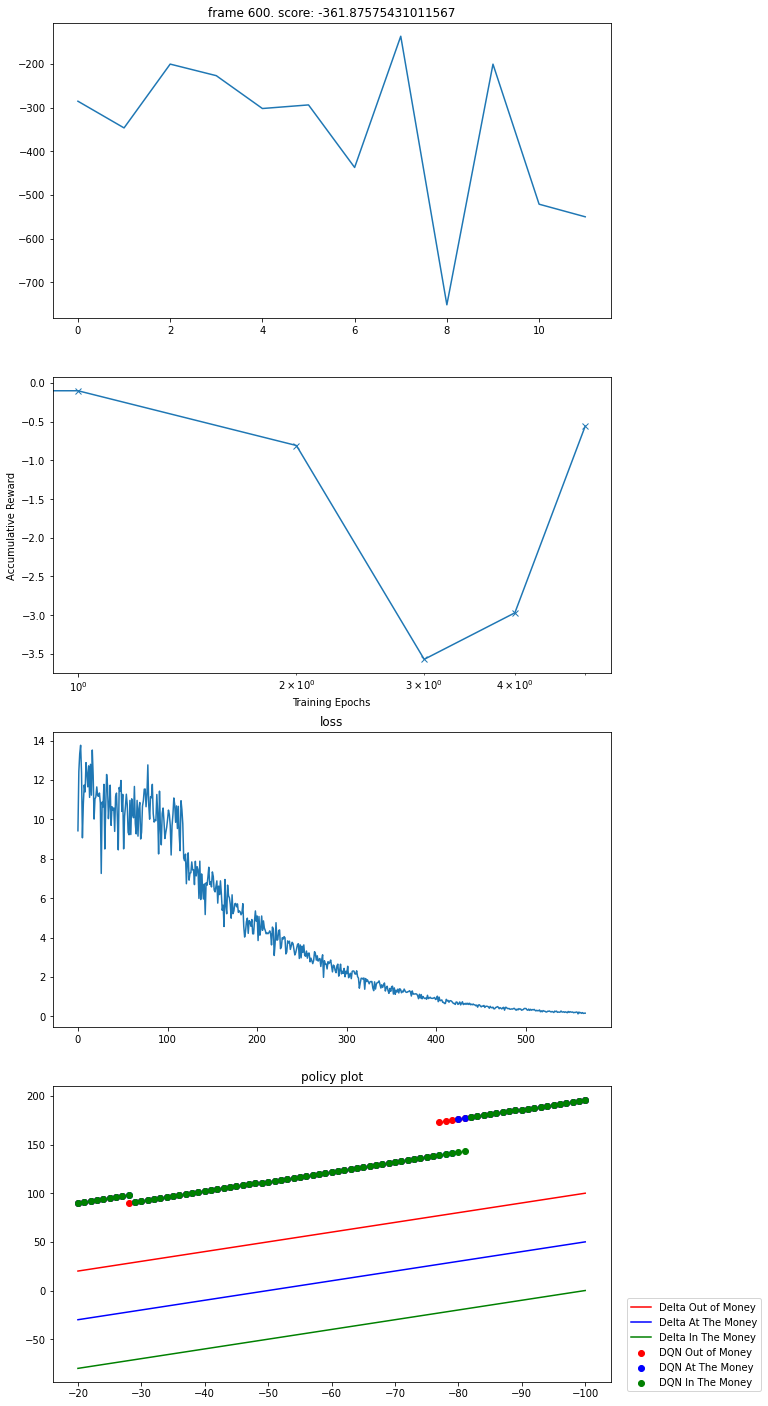

2021-12-19 14:36:33 INFO     Entering step 1 of 50 | action = 170
2021-12-19 14:36:33 INFO     Action: 170 Trade {Stock(is_tradable=True, ticker='AAPL', dividend=0.0): 70}
2021-12-19 14:36:33 INFO     Returning from step 1 of 50 | observation=[9.9327774e+01 3.2440484e+00 1.0000000e+00 2.0000000e-02 7.0000000e+01
 0.0000000e+00 0.0000000e+00], reward=-35.11454071727646, done=False
2021-12-19 14:36:34 INFO     Entering step 2 of 50 | action = 94
2021-12-19 14:36:34 INFO     Action: 94 Trade {Stock(is_tradable=True, ticker='AAPL', dividend=0.0): -6}
2021-12-19 14:36:34 INFO     Returning from step 2 of 50 | observation=[ 9.8327942e+01  2.7715793e+00  1.0000000e+00  3.9999999e-02
 -6.0000000e+00  0.0000000e+00  0.0000000e+00], reward=-49.75482452638518, done=False
2021-12-19 14:36:34 INFO     Entering step 3 of 50 | action = 127
2021-12-19 14:36:34 INFO     Action: 127 Trade {Stock(is_tradable=True, ticker='AAPL', dividend=0.0): 27}
2021-12-19 14:36:34 INFO     Returning from step 3 of 50 

KeyboardInterrupt: 

In [13]:
agent.train(num_frames)

In [ ]:
prev_pos = None
preds = []

for _t in sorted(obs_input['normalized_time'].unique()):
    prev_pos = np.ones(obs_input['episode_idx'].max() + 1) * INIT_STOCK_HOLDINGS if prev_pos is None else prev_pos
    obs = np.hstack([obs_input.loc[obs_input['normalized_time'] == _t, ['price', 'call_price', 'all_1', 'normalized_time',]].values, prev_pos[:, np.newaxis], np.zeros((obs_input['episode_idx'].max() + 1, 2))])
    pred = np.zeros(len(obs))
    for j in range(len(obs)):
        pred[j] = agent.select_action(obs[j]) - 100
    prev_pos = pred
    preds.append(pred)

obs_input['holdings'] = np.concatenate(preds)
obs_input

In [ ]:
obs_input = obs_input.sort_values(['episode_idx', 'normalized_time'])

In [ ]:
def calculate_reward_vectorize(res):
    res['delta_wealth'] = res['holdings'].shift() * res['price'] + 100 * res['call_price'] - (res['holdings'] * res['price'] + 100 * res['call_price']).shift()
    res.loc[res['normalized_time']==res['normalized_time'].min(), 'delta_wealth'] = 0.
    res['reward'] = res['delta_wealth'] ** 2 * -0.5 * REWARD_KAPPA + res['delta_wealth']
    return res

In [ ]:
obs_input = calculate_reward_vectorize(obs_input)

obs_input

In [ ]:
sample_experiment = obs_input.query('episode_idx=99')

In [ ]:
sample_experiment

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].plot(np.arange(50), sample_experiment.delta * -100, '-')
axes[0].plot(np.arange(50), sample_experiment.holdings, '*-')
axes[1].plot(np.arange(50), ((sample_experiment['price'].shift(-1) - sample_experiment['price']) * sample_experiment['holdings']).cumsum(), 'v-')
axes[1].plot(np.arange(50), ((sample_experiment['call_price'].shift(-1) - sample_experiment['call_price']) * 100).cumsum(), 'x-')